# Local Events Visualization

The purpose of this notebook is to visualize results from the local earthquake picking workflow.

In [1]:
"""
Description:
    This notebook is used for plotting events identified using the local earthquake picking
    workflow.
    
CreationDate:   10/03/20
Developer:      rakib.hassan@ga.gov.au
 
Revision History:
    LastUpdate:     10/03/20   RH

"""

import datetime
import glob, os, sys
from os.path import join, exists
import obspy
from obspy.core import Stream, UTCDateTime
from obspy import read, Trace
from obspy.signal.cross_correlation import xcorr
import numpy as np
import matplotlib
import logging
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import scipy
import math
from collections import defaultdict
from netCDF4 import Dataset

from obspy.signal.detrend import simple, spline
from obspy.signal.filter import bandpass

sys.path.append('/g/data1a/ha3/rakib/seismic/pst/passive-seismic')
from seismic.ASDFdatabase.FederatedASDFDataSet import FederatedASDFDataSet

import json
import ijson
from collections import defaultdict
from rtree import index
import pywt
from scipy.signal import savgol_filter
from obspy import UTCDateTime, read_events, read_inventory
from obspy.taup.taup_geo import calc_dist
from obspy.clients.iris import Client as IrisClient
from obspy.clients.fdsn import Client
from obspy.taup import TauPyModel
from lxml import etree as ET
from obspy.signal.trigger import trigger_onset, z_detect, classic_sta_lta, recursive_sta_lta, ar_pick
from obspy.signal.rotate import rotate_ne_rt
from obspy.core.event import Pick, CreationInfo, WaveformStreamID, ResourceIdentifier, Arrival, Event,\
Origin, Arrival, OriginQuality, Magnitude, Comment
from seismic.pick_harvester.utils import EventParser, Catalog, CatalogCSV, ProgressTracker
from mpl_toolkits.basemap import Basemap

%matplotlib inline

In [2]:
fds = FederatedASDFDataSet('/g/data/ha3/Passive/SHARED_DATA/Index/asdf_files.txt')

Found database: /g/data/ha3/Passive/SHARED_DATA/Index/778837537aa72d892df7b0ba22320f537c1d8f6a.db


## Parse Results in XML Events File

In [27]:
events  = []
origins = []

for xmlevent, elem in ET.iterparse('/g/data/ha3/Passive/SHARED_DATA/Scratch/local_picking_workflow/results/events_oa2.xml'):
    tag = ET.QName(elem.tag).localname
    if (tag.upper() == 'EVENT'):
        events.append(elem)
    elif (tag.upper() == 'ORIGIN'):
        origins.append(elem)
    # end if
# end for

In [28]:
class Origin:
    def __init__(self, utctime, lat, lon, depthkm):
        self.utctime = utctime
        self.lat = lat
        self.lon = lon
        self.depthkm = depthkm
    # end func
# end class

class Event:
    def __init__(self):
        self.public_id = None
        self.preferred_origin = None
        self.origin_list = []
    # end func
# end class

In [29]:
origin_dict = defaultdict(list)
event_dict = defaultdict(list)

def parseOrigin(o):
    utctime = None
    lat = None
    lon = None
    depthkm = None
    pref_mag = None
    magList = []
    
    rejected = False
    for element in o:
        if ('time' in element.tag):
            for subelement in element:
                if ('value' in subelement.tag):
                    utctime = UTCDateTime(subelement.text)
                    # end if
                    # end for
        elif ('latitude' in element.tag):
            for subelement in element:
                if ('value' in subelement.tag):
                    lat = float(subelement.text)
                # end if
            # end for
        # end if
        elif ('longitude' in element.tag):
            for subelement in element:
                if ('value' in subelement.tag):
                    lon = float(subelement.text)
                # end if
            # end for
        # end if
        elif ('depth' in element.tag):
            for subelement in element:
                if ('value' in subelement.tag):
                    depthkm = float(subelement.text)
                # end if
            # end for
        elif('evaluationStatus' in element.tag):
            if(element.text == 'rejected'):
                rejected = True
                break
            # end if
        # end if
    # end for

    if(rejected): return None
    assert None not in [utctime, lat, lon], 'Failed to find required values for Origin'

    o = Origin(utctime, lat, lon, depthkm)
    return o
# end func

# parse origins
for o in origins:
    pid = o.get('publicID')
    origin_dict[pid] = parseOrigin(o)
# end for
assert len(origins) == len(origin_dict), 'Invalid originIDs found..'

## Parse Origins and Allocate Events to Day-bins

In [30]:
dayEvents = defaultdict(list)
def parseEvent(e):
    resultEvent = Event()
    origList = []

    resultEvent.public_id = e.get('publicID')
    for element in e:
        if ('preferredOriginID' in element.tag):
            oid = element.text
            resultEvent.preferred_origin = origin_dict[oid]    
            
            if(origin_dict[oid]): 
                print origin_dict[oid].utctime.strftime("%A, %d. %B %Y %H:%M:%s %p")
        # end if
    # end for
    resultEvent.origin_list = origList
    return resultEvent
# end func

# parse events
for e in events:
    pid = e.get('publicID')
    event_dict[pid] = parseEvent(e)
    
    if(event_dict[pid].preferred_origin):
        day_timestamp = UTCDateTime(event_dict[pid].preferred_origin.utctime.strftime('%Y-%m-%d')).timestamp
        dayEvents[day_timestamp].append(event_dict[pid])
# end for
assert len(events) == len(event_dict), 'Invalid eventIDs found..'

Saturday, 18. May 2019 09:41:1558136508 AM
Sunday, 19. May 2019 02:53:1558198417 AM
Sunday, 19. May 2019 03:20:1558200059 AM
Sunday, 19. May 2019 07:32:1558215176 AM
Sunday, 19. May 2019 07:34:1558215297 AM
Monday, 20. May 2019 06:55:1558299351 AM
Tuesday, 21. May 2019 07:03:1558386236 AM
Tuesday, 21. May 2019 11:51:1558403500 AM
Tuesday, 21. May 2019 18:44:1558428298 PM
Wednesday, 22. May 2019 01:41:1558453263 AM
Wednesday, 22. May 2019 06:57:1558472233 AM
Wednesday, 22. May 2019 10:56:1558486594 AM
Wednesday, 22. May 2019 11:19:1558487978 AM
Thursday, 23. May 2019 11:33:1558575227 AM
Thursday, 23. May 2019 17:49:1558597773 PM
Thursday, 23. May 2019 18:01:1558598506 PM
Friday, 24. May 2019 04:21:1558635680 AM
Friday, 24. May 2019 18:32:1558686736 PM
Saturday, 25. May 2019 09:50:1558741815 AM
Saturday, 25. May 2019 13:09:1558753762 PM
Saturday, 25. May 2019 16:19:1558765184 PM
Sunday, 26. May 2019 07:13:1558818804 AM
Sunday, 26. May 2019 16:22:1558851752 PM
Sunday, 26. May 2019 21:31:1

## Read Station Coordinates

In [31]:
slonlat = []
for item in fds.unique_coordinates.keys():
    if ('OA.' in item):
        slonlat.append(fds.unique_coordinates[item])
    # end if
# end for

slonlat = np.array(slonlat)
print slonlat.shape

(229, 2)


## Plot All Events

110 Events


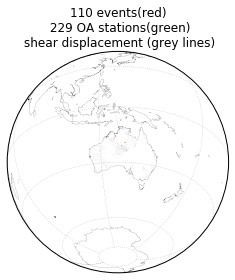

In [32]:
fig, ax = plt.subplots()

fig.set_size_inches(8,4)

m = Basemap(projection='ortho',lon_0=130,lat_0=-30,resolution='l')
lons = []
lats = []
mags = []
for k,e in event_dict.iteritems():
    if(isinstance(e.preferred_origin, Origin)):
        lons.append(e.preferred_origin.lon)
        lats.append(e.preferred_origin.lat)
        mags.append(3)
    # end if
# end for

mags = np.array(mags)
lons = np.array(lons)
lats = np.array(lats)
print len(lons), 'Events'
px,py = m(lons, lats)
spx,spy = m(slonlat[:,0], slonlat[:,1])

m.drawparallels(np.arange(-90.,120.,30.), linewidth=0.1)
m.drawmeridians(np.arange(0.,420.,60.), linewidth=0.1)
m.drawcoastlines(linewidth=0.1)

cbinfo = m.scatter(spx, spy, c='g', s=.05, marker='v',
          cmap='cool', edgecolor='none', alpha=0.75,
          vmin=3,
          rasterized=False)

cbinfo = m.scatter(px, py, c='r', s=.05, 
          cmap='cool', edgecolor='none', 
          vmin=3,
          rasterized=False)

m.readshapefile('data/ShearDisplacementLines2_5M', 'shear', drawbounds = False)

for info, shape in zip(m.shear_info, m.shear):
    x, y = zip(*shape) 
    m.plot(x, y, marker=None, color='k', alpha=0.1, lw=0.1)
# end for

plt.title('%d events(red)\n %d OA stations(green)\n shear displacement (grey lines)'%(len(lons),
                                                                                    len(spx)))
plt.tight_layout()
plt.savefig('/g/data/ha3/Passive/SHARED_DATA/Scratch/local_picking_workflow/results/events_oa2.png', dpi=1200)

## Plot Events for Each Day

1 Events tmp.000.png 2019-05-18
4 Events tmp.001.png 2019-05-19
1 Events tmp.002.png 2019-05-20
3 Events tmp.003.png 2019-05-21
4 Events tmp.004.png 2019-05-22
3 Events tmp.005.png 2019-05-23
2 Events tmp.006.png 2019-05-24
3 Events tmp.007.png 2019-05-25
3 Events tmp.008.png 2019-05-26
3 Events tmp.009.png 2019-05-27
4 Events tmp.010.png 2019-05-28
5 Events tmp.011.png 2019-05-29
17 Events tmp.012.png 2019-05-30
5 Events tmp.013.png 2019-05-31
2 Events tmp.014.png 2019-06-01
4 Events tmp.015.png 2019-06-02
2 Events tmp.016.png 2019-06-03
6 Events tmp.017.png 2019-06-04
2 Events tmp.018.png 2019-06-05
5 Events tmp.019.png 2019-06-08
5 Events tmp.020.png 2019-06-09
3 Events tmp.021.png 2019-06-10
9 Events tmp.022.png 2019-06-11
6 Events tmp.023.png 2019-06-12
4 Events tmp.024.png 2019-06-13
4 Events tmp.025.png 2019-06-14


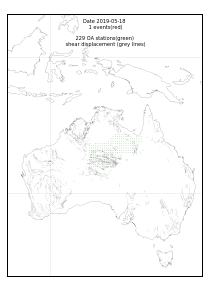

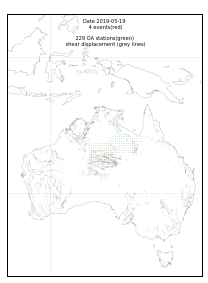

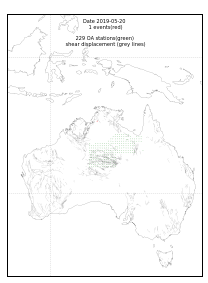

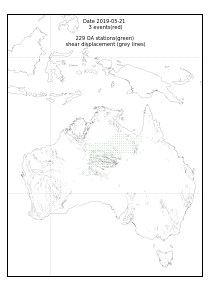

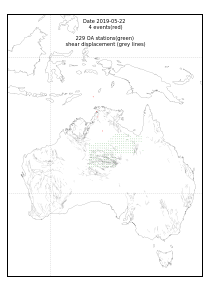

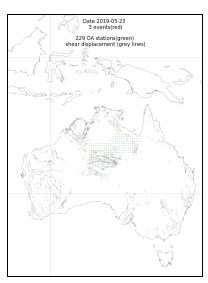

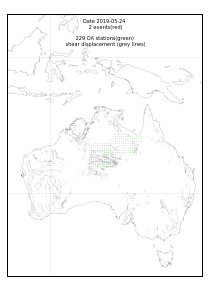

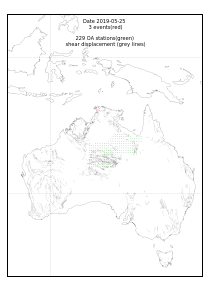

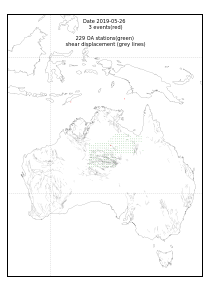

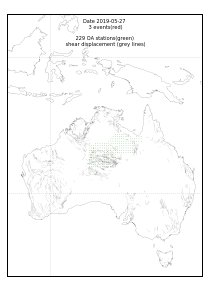

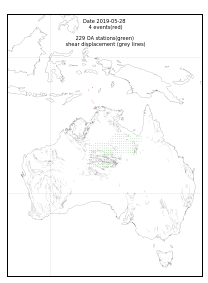

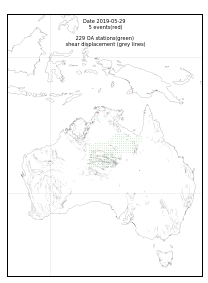

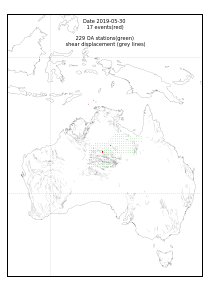

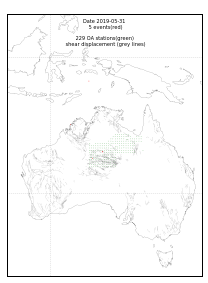

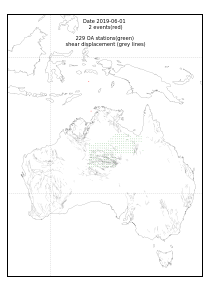

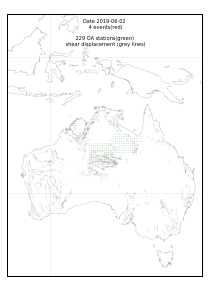

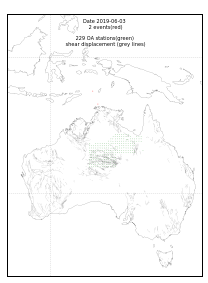

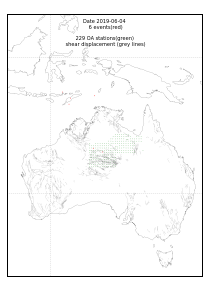

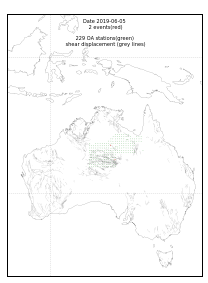

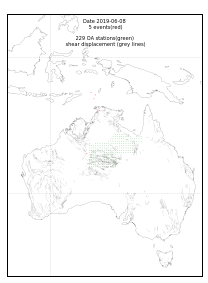

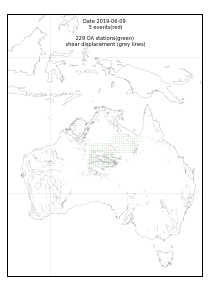

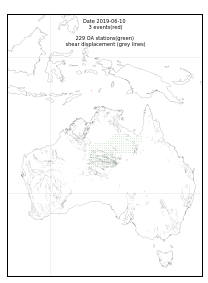

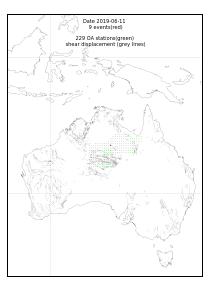

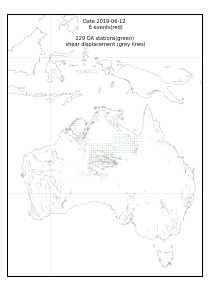

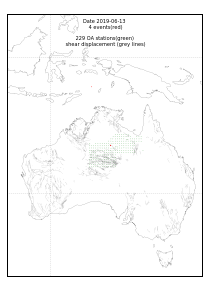

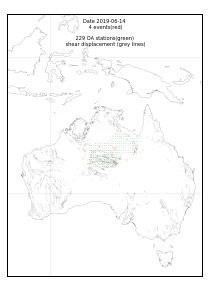

In [26]:

for di,k in enumerate(sorted(dayEvents.keys())):
    v = dayEvents[k]
    
    fig, ax = plt.subplots()
    fig.set_size_inches(3,4)

    m = Basemap(projection='ortho',lon_0=130,lat_0=-30,resolution='l')
    m = Basemap(ax=ax,projection='merc', lat_ts=-27, llcrnrlat=-45,urcrnrlat=10,\
            llcrnrlon=110,urcrnrlon=155, resolution='l')
    lons = []
    lats = []
    mags = []
    for e in v:
        if(isinstance(e.preferred_origin, Origin)):
            lons.append(e.preferred_origin.lon)
            lats.append(e.preferred_origin.lat)
            mags.append(3)
        # end if
    # end for

    mags = np.array(mags)
    lons = np.array(lons)
    lats = np.array(lats)
    
    px,py = m(lons, lats)
    spx,spy = m(slonlat[:,0], slonlat[:,1])

    m.drawparallels(np.arange(-90.,120.,30.), linewidth=0.1)
    m.drawmeridians(np.arange(0.,420.,60.), linewidth=0.1)
    m.drawcoastlines(linewidth=0.1)

    cbinfo = m.scatter(spx, spy, c='g', s=.5, marker='v',
              cmap='cool', edgecolor='none', alpha=0.75,
              vmin=3,
              rasterized=False)

    cbinfo = m.scatter(px, py, c='r', s=.5, 
              cmap='cool', edgecolor='none', 
              vmin=3,
              rasterized=False)

    if (1):
        m.readshapefile('data/ShearDisplacementLines2_5M', 'shear', drawbounds = False)

        for info, shape in zip(m.shear_info, m.shear):
            x, y = zip(*shape) 
            m.plot(x, y, marker=None, color='k', alpha=0.5, lw=0.1)
        # end for
    # end for
    
    fig.suptitle('\n\nDate %s\n %d events(red)\n\n %d '\
              'OA stations(green)\n shear displacement (grey lines)'%(UTCDateTime(k).strftime('%Y-%m-%d'),
                                                                      len(lons), len(spx)),
                fontsize=5)
    plt.tight_layout()
    print len(lons), 'Events', 'tmp.%03d.png'%(di), UTCDateTime(k).strftime('%Y-%m-%d')
    plt.savefig('/g/data/ha3/Passive/SHARED_DATA/Scratch/local_picking_workflow/results/oa2/tmp.%03d.png'%(di), dpi=1200)        
    #break
# end for    